<a href="https://colab.research.google.com/github/interngithub2020/RF_modulation_classification/blob/master/model_evaluation_radioml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and aims of this notebook

This notebook compares the best performing models and feature types for modulation classification, draws insights from this comparison and acts on these insights to combine models for better performance. Different models were explored in another notebook, and CLDNN was selected as the best-performing model.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/mod_rec/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
#%reset
%tensorflow_version 1.x
from sklearn.externals import joblib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, PReLU
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform, Constant
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Training parameters and helper functions

Here I set training parameters and helper functions used in common across all models. 

## Variables used for training the models



In [ ]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 1024 #time-series
PATIENCE = 10

## Functions for data conversion

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
def arr2img(arr, chnum):
  norm = plt.Normalize(vmin=arr.min(), vmax=arr.max())
  if chnum == 1:
      cmap = plt.cm.gray
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,0] #All RGBA channels identical
      
  elif chnum == 3:
      cmap = plt.cm.hot #or can choose any other colormap
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,:3] #ignore A channel
    
  return img

## Functions for generating and plotting confusion matrices


In [ ]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

## Label encoder class of functions

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

## ModelEvaluater Class of functions for training and evaluation
(1) formatting label data into one-hot format,  

(2) fitting model with training data,

(3) evaluating model using accuracy plots and confusion matrices

During fitting, Model Checkpoints are set so that weights files are automatically saved when validation loss decreases. There is also earlystopping, for which the default patience is 10 epochs. 

During print_summary(), the model is evaluated on the test set and prints out the confusion matrices for different SNRs and a graph showing accuracy over different SNRs.

Example on using ModelEvaluater class: 

    fc_model = build_fc_net(X_test.shape[1],X_teat.shape[2])
    fc_model_evaluater = ModelEvaluater(fc_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE,  'fc-net' )
    fc_model_evaluater.fit(EPOCHS, patience=10)
    fc_model_evaluater.print_summary()


In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + '%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
  
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    snr_ranges = [(-20, 20),(-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]

      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()


  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

  
  def confmat_snr(self, snr_rng):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

# Loading and formatting of data

In a python script, I divided the radioML dataset into a train-val-test split of 0.67 - 0.13 - 0.2, and stored them in 'rml_trainvaltest.hdf5'. They have already been shuffled, so simply load them as below.

More information about the source:
The 2016.10A radioML dataset (download here https://www.deepsig.ai/datasets) is a python dictionary with keys (mod, SNR) and values being an array of samples of 2x128 time-series I/Q data. It contains 11 types of modulations of varying SNR, and also contains some simulated channel effects. Refer to [Radio Machine Learning Dataset Generation with GNU Radio](https://pubs.gnuradio.org/index.php/grcon/article/view/11) for more information on the dataset.

In [ ]:
from sklearn.externals import joblib
data = joblib.load(root_path + 'data/rml_trainvaltest.hdf5')

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['val', 'train', 'test'])
Train val test size:  (107200, 2, 128) (20800, 2, 128) (32000, 2, 128)
Check if data is shuffled:  [['d4PAM' '16']
 ['a16QAM' '0']
 ['cGFSK' '-20']
 ['dBPSK' '4']
 ['d4PAM' '-20']
 ['cCPFSK' '-2']
 ['dBPSK' '-4']
 ['d4PAM' '-16']
 ['a16QAM' '-20']
 ['a64QAM' '2']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [5422 5363 5335 5362 5333 5279 5310 5330 5316 5390 5436 5326 5334 5445
 5393 5385 5319 5399 5372 5351]
Check modulation types:  ['a16QAM' 'a64QAM' 'b8PSK' 'bQPSK' 'cCPFSK' 'cGFSK' 'd4PAM' 'dBPSK']
Check distribution of samples across modulation types:  [13373 13373 13401 13445 13452 13345 13502 13309]


## Load raw IQ train, val, test data

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

### Only retain data with SNR >= -10 for fair comparison with constellation models

The constellation models had been trained only with higher SNR data of >=-10dB for faster training, so here I also retrain the time-series model with only higher SNR data.

In [ ]:
#only retain data with snr >= -10
snrs = labels_train[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_train = X_train[idx]
labels_train = labels_train[idx]
y_train = labels_train[:,0]

snrs = labels_val[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_val = X_val[idx]
labels_val = labels_val[idx]
y_val = labels_val[:,0]

snrs = labels_test[:,1]
snrs = np.array([int(snr) for snr in snrs])
idx = np.where(snrs >= -10)
X_test = X_test[idx]
labels_test = labels_test[idx]
y_test = labels_test[:,0]

### Convert to ampphase

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

## Load train, val, test constellation data
Here, I only load the constellations with resolution = 32 and no colours because all the constellation models performed similarly (see other notebook), so I might as well use the constellations that take up the least memory.

In [ ]:
from sklearn.externals import joblib
data_constel = joblib.load(root_path + 'data/rml_trainvaltest_constel32_1.hdf5')

In [ ]:
#load data
X_img_train = data_constel['train']['X']
y_img_train = data_constel['train']['labels'][:,0]
labels_img_train = data_constel['train']['labels'] 

X_img_val = data_constel['val']['X']
y_img_val = data_constel['val']['labels'][:,0]
labels_img_val = data_constel['val']['labels'] 

X_img_test = data_constel['test']['X']
y_img_test = data_constel['test']['labels'][:,0]
labels_img_test = data_constel['test']['labels'] 

In [ ]:
del data_constel

In [ ]:
nbins = X_img_train.shape[1]
c = 1
X_img_train = X_img_train.reshape(-1, nbins, nbins, c)
X_img_val = X_img_val.reshape(-1, nbins, nbins, c)
X_img_test = X_img_test.reshape(-1, nbins, nbins, c)

# Preparing and loading models for comparison

## Time-series: Retraining CLDNN model on only snr >= -10dB

From: [Deep Architectures for Modulation Recognition](https://arxiv.org/abs/1703.09197)

Convolutional layer followed by LSTM layers, with first convolutional layer output going directly to the LSTM in the last layer. This approach is popular with time-series, with the convolutional layers first removing noise and extracting important features, and the recurrent unit (LSTM) retaining memory of previous elements in the time-series.

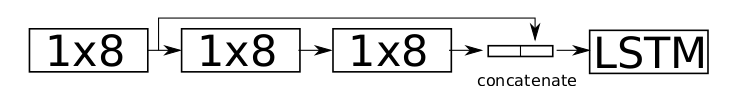

In [ ]:
def build_cldnn_net(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", init='glorot_uniform', data_format="channels_first")(input_x_padding)
  layer1 = Dropout(dr)(layer1)
  layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", init='glorot_uniform', data_format="channels_first")(layer1_padding)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", init='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)

  concat = keras.layers.concatenate([layer1, layer3])
  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='relu', init='he_normal', name="dense1")(lstm_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, init='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

### IQ retraining


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 1, 2, 132)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

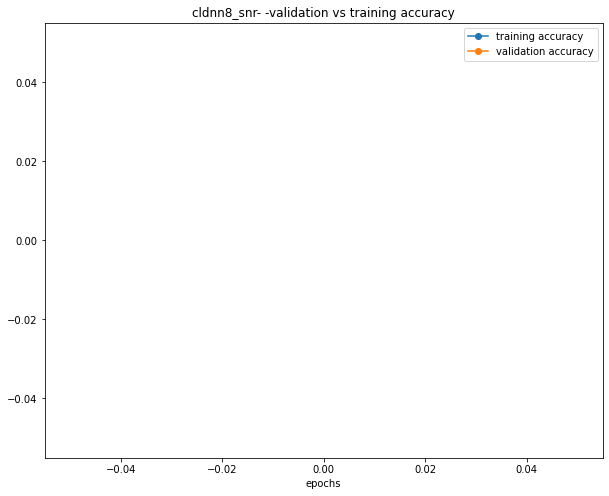

None

(23873, 1, 2, 128)
(23873, 8)
[    0     1     2 ... 23870 23871 23872]


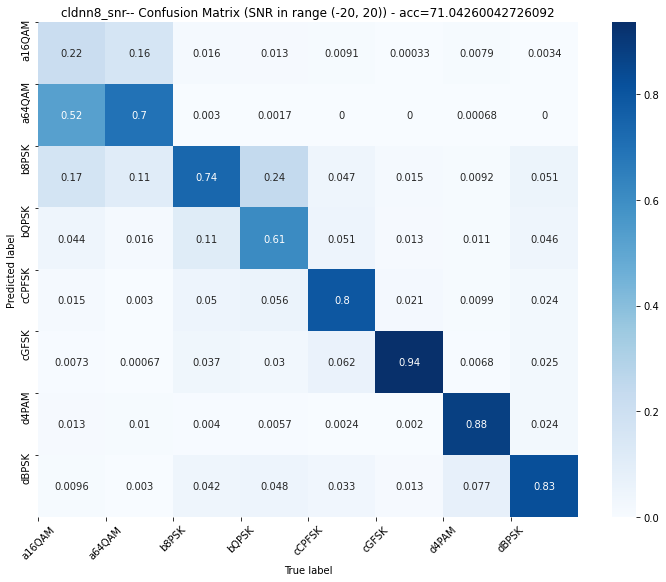

(23873, 1, 2, 128)
(23873, 8)
[    2     3     6 ... 23865 23868 23870]


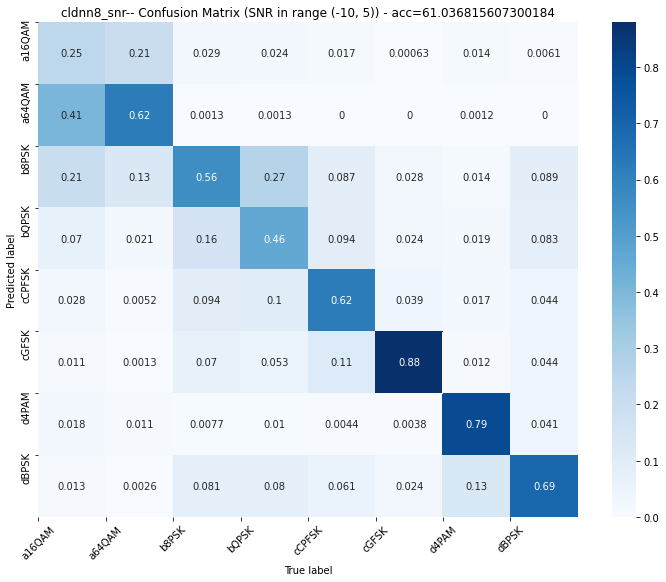

(23873, 1, 2, 128)
(23873, 8)
[    0     1     4 ... 23869 23871 23872]


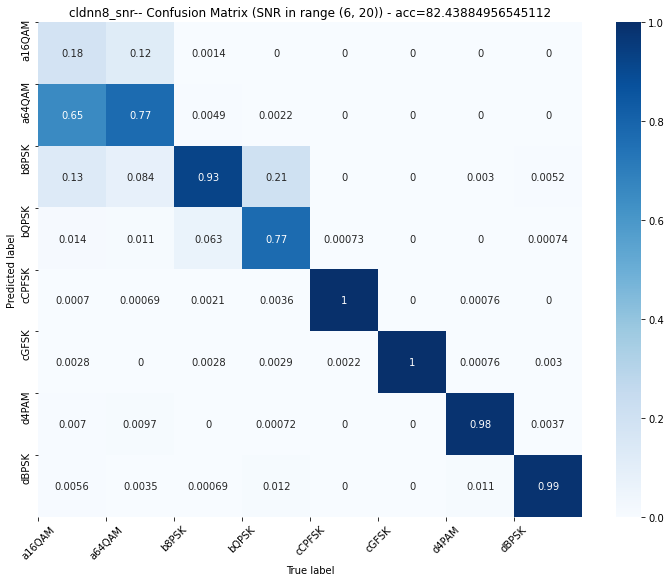

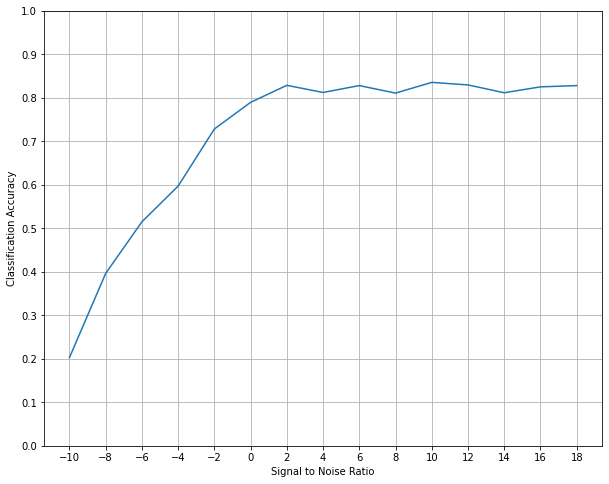

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'cldnn8_snr--weights-94.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8_snr-' )
#cldnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_model_evaluater.print_summary()

If we compare to the time-series_classification.ipynb notebook, actually training with SNR<-10dB worsens the model peformance slightly. Maybe because smaller training set and data too clean, so more overfitting.

### AP retraining

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 1, 2, 132)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

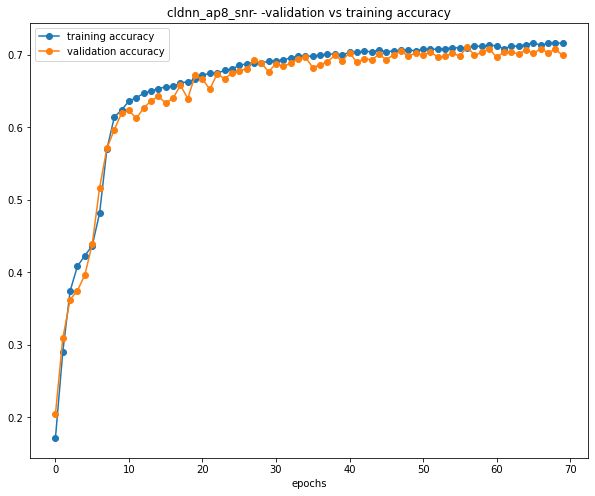

None

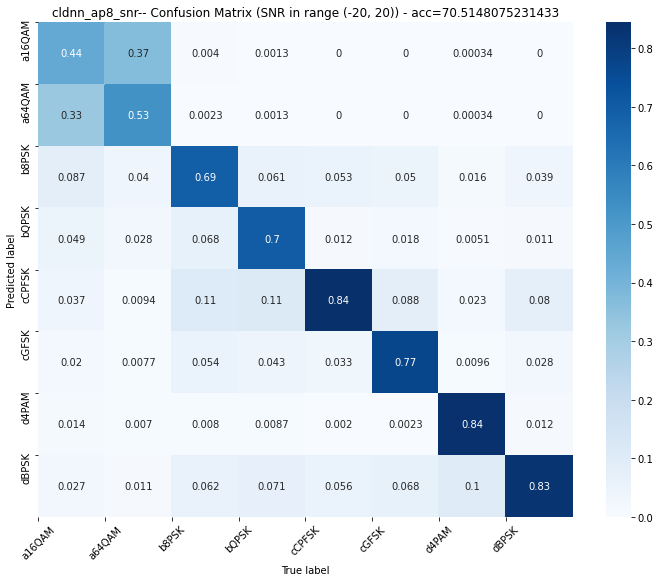

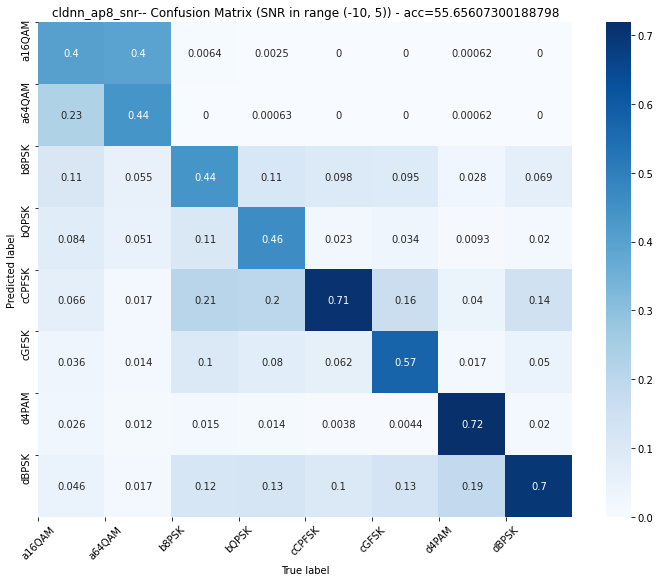

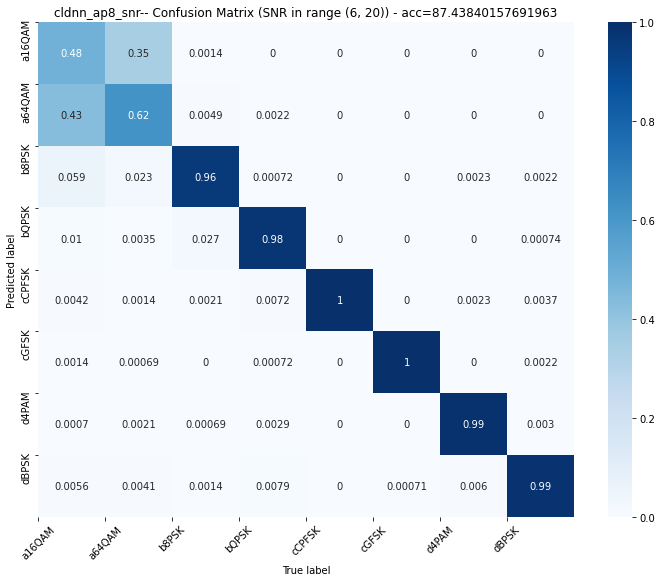

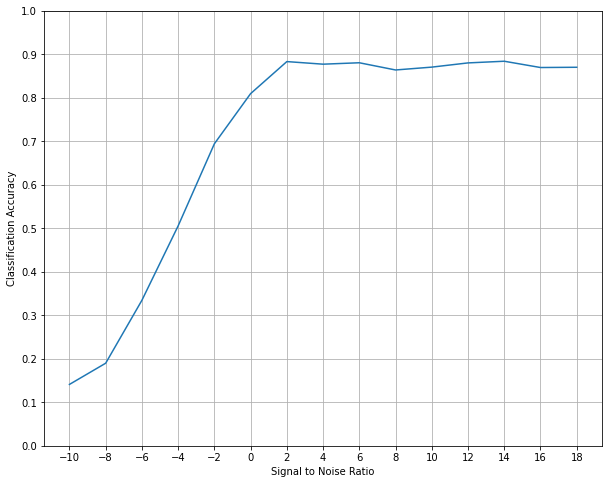

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8_snr-' )
cldnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_ap_model_evaluater.print_summary()

For amp-phase, training with SNR>=-10 actually makes performance worse than training with also the noisy data. (In the other notebook, cldnn-ap achieved 93% accuracy at high SNR).  Perhaps training with low SNR data also helps to prevent overfitting.

## Constellation classifier: Model architecture

From: [Data-Driven Deep Learning for Automatic Modulation Recognition in Cognitive Radios](https://ieeexplore.ieee.org/document/8645696) 

This model consists of five convolutional layers and three dense layers, similar to a standard AlexNet. 

In [ ]:
def build_constellation_net(X1, X2, X3):
  model = Sequential()
  model.add(Reshape((X1, X2, X3), input_shape=(X1, X2, X3)))
  model.add(Conv2D(128, (5,5), padding='valid', data_format="channels_last"))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))  
  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(Dropout(0.5))
  model.add(Dense(512))
  model.add(PReLU(alpha_initializer=Constant(value=0.25)))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #smaller loss better for images
  model.summary()
  return model

# Comparison between IQ, AP, and constellation models and drawing insights

In [ ]:
#CLDNN trained on low, med, high SNRs
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'cldnn8--weights-66.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_test2, y_test,X_test2, y_test, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8-' )
cldnn_accpersnr = cldnn_model_evaluater.accpersnr_model()


X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model.load_weights(root_path + 'cldnn_ap8--weights-68.hdf5')
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_test2, y_test, X_ap_test2, y_test, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8-' )
cldnn_ap_accpersnr = cldnn_ap_model_evaluater.accpersnr_model()


#CLDNN trained on med and high SNRs only
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model2 = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model2.load_weights(root_path + 'cldnn8_snr--weights-94.hdf5')
cldnn_model2_evaluater = ModelEvaluater(cldnn_model2, X_test2, y_test,X_test2, y_test, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8-' )
cldnn2_accpersnr = cldnn_model2_evaluater.accpersnr_model()

X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model2 = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model2.load_weights(root_path + 'cldnn_ap8_snr--weights-60.hdf5')
cldnn_ap_model2_evaluater = ModelEvaluater(cldnn_ap_model2, X_ap_test2, y_test, X_ap_test2, y_test, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8-' )
cldnn_ap2_accpersnr = cldnn_ap_model2_evaluater.accpersnr_model()


#Constellation
constellation_32_1_model = build_constellation_net(X_img_test.shape[1], X_img_test.shape[2], X_img_test.shape[3])
constellation_32_1_model.load_weights(root_path + 'constel32_1-weights-38.hdf5')
constellation_32_1_model_evaluater = ModelEvaluater(constellation_32_1_model, X_img_test, y_img_test, X_img_test, y_img_test, X_img_test, y_img_test, labels_img_test, 64, 'constel32_1' )
acc321 = constellation_32_1_model_evaluater.accpersnr_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_52 (ZeroPadding2 (None, 1, 2, 132)    0           input_18[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_52[0][0]          
__________________________________________________________________________________________________
dropout_75 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_55 (ZeroPadding2 (None, 1, 2, 132)    0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_55[0][0]          
__________________________________________________________________________________________________
dropout_79 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_58 (ZeroPadding2 (None, 1, 2, 132)    0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_58[0][0]          
__________________________________________________________________________________________________
dropout_83 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_61 (ZeroPadding2 (None, 1, 2, 132)    0           input_21[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_61[0][0]          
__________________________________________________________________________________________________
dropout_87 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

## Observations of performance at different SNRs

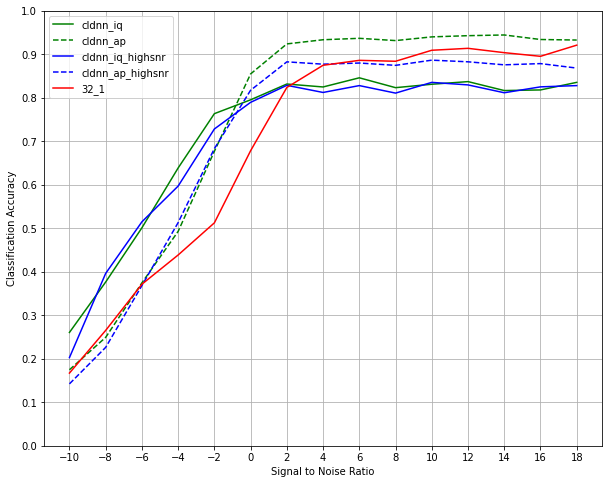

In [ ]:
# plot acc-vs-snr graphs for different models
cldnn, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g-', label='cldnn_iq')
cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g--', label='cldnn_ap')
cldnn2, = plt.plot(list(cldnn2_accpersnr.keys()),list(cldnn2_accpersnr.values()), 'b-', label='cldnn_iq_highsnr')
cldnn_ap2, = plt.plot(list(cldnn_ap2_accpersnr.keys()),list(cldnn_ap2_accpersnr.values()), 'b--', label='cldnn_ap_highsnr')
_acc321,  = plt.plot(list(acc321.keys()),list(acc321.values()), 'r-', label='32_1')

plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.xticks(list(cldnn_accpersnr.keys()))
plt.legend(handles = [cldnn, cldnn_ap, cldnn2, cldnn_ap2,_acc321])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()

(1) When trained on low SNR together with high SNR data, CLDNN performs signifcantly better especially when input is in amp-phase format. One reason is a larger training set, another reason is perhaps reducing overfitting.

(2) CLDNN-AP performs the best at high SNR, and constellation also performs quite well, especially considering that performance would likely improve with higher resolution of constellation image.

(3) IQ model performs the best at low SNR, while constellation model only performs well at >-2dB.

## Observations of confusion matrices

CLDNN trained on low, med, high SNRs


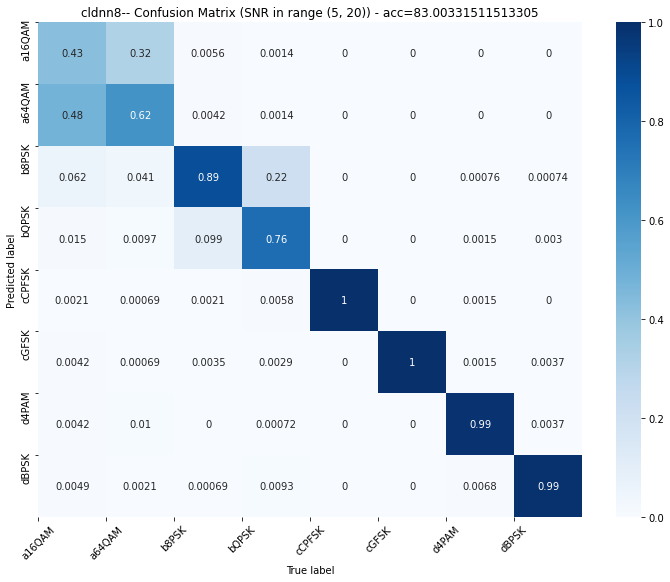

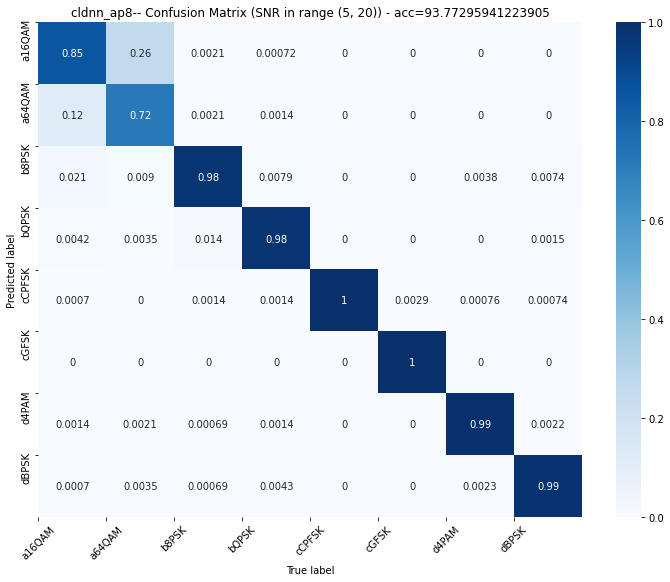

CLDNN trained on med and high SNRs only


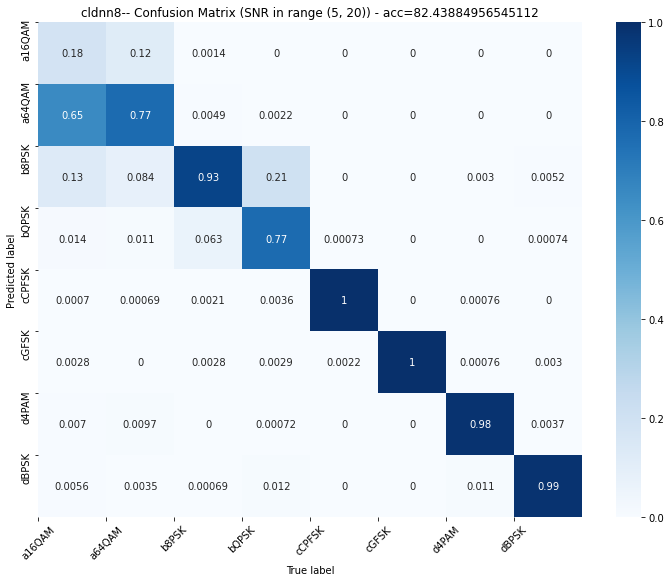

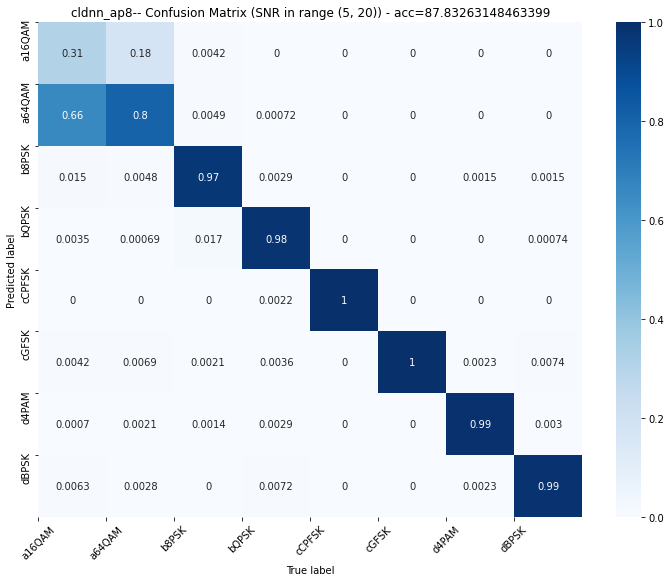

Constellation


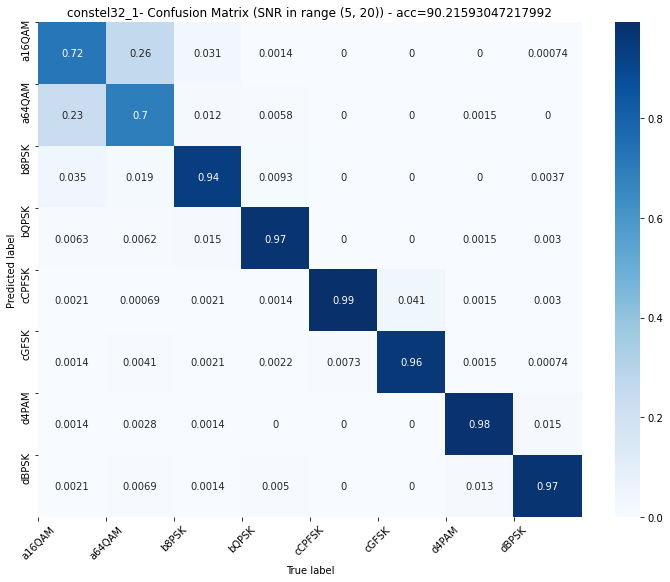

In [ ]:
snr_range = (5, 20)
print("CLDNN trained on low, med, high SNRs")
cldnn_model_evaluater.confmat_snr(snr_range)
cldnn_ap_model_evaluater.confmat_snr(snr_range)

print("CLDNN trained on med and high SNRs only")
cldnn_model2_evaluater.confmat_snr(snr_range)
cldnn_ap2_accpersnr = cldnn_ap_model2_evaluater.confmat_snr(snr_range)

print("Constellation")
acc321 = constellation_32_1_model_evaluater.confmat_snr(snr_range)

From the confusion matrices, we still see that CLDNN_AP is the best at distinguishing between QAMs, followed closely by the constellation model. IQ model is perfect at telling apart modulations other than QAMs and PSKs.

And constellation model is not as perfect at telling apart other modulations as time-series model.

## Higher resolution constellations and QAMs
To prove the point that higher resolution constellation will be better able to differentiate between QAMs, I trained the constellation model with 96x96x1 images belonging only to QAM modulations, ranging across the entire SNR range, with the training process and testing results from that notebook pasted below. But of course the tradeoff is memory consumed compared to simple time-series.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 128)       3328      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 92, 92, 128)       1083392   
_________________________________________________________________
average_pooling2d_1 (Average (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        73792     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 46, 46, 64)        135424    
______________________________________

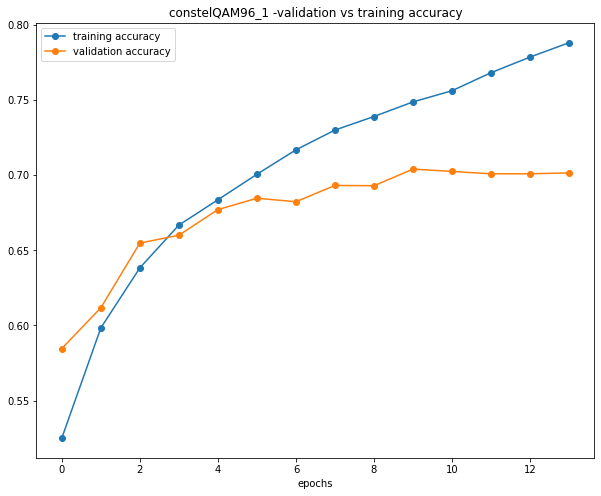

None

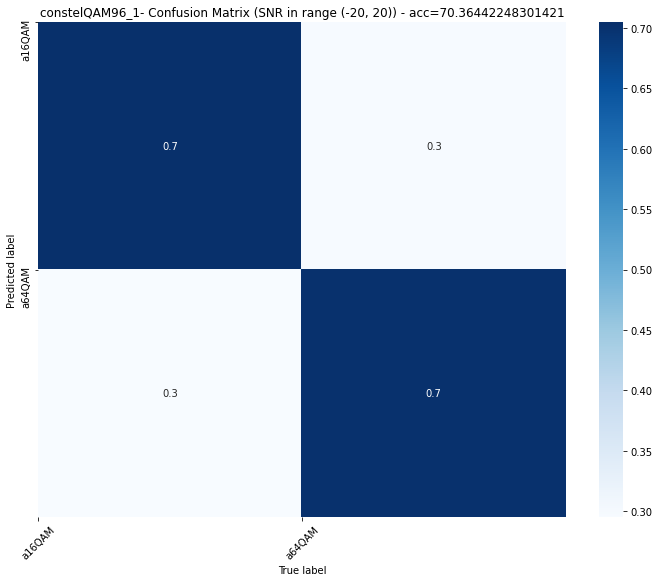

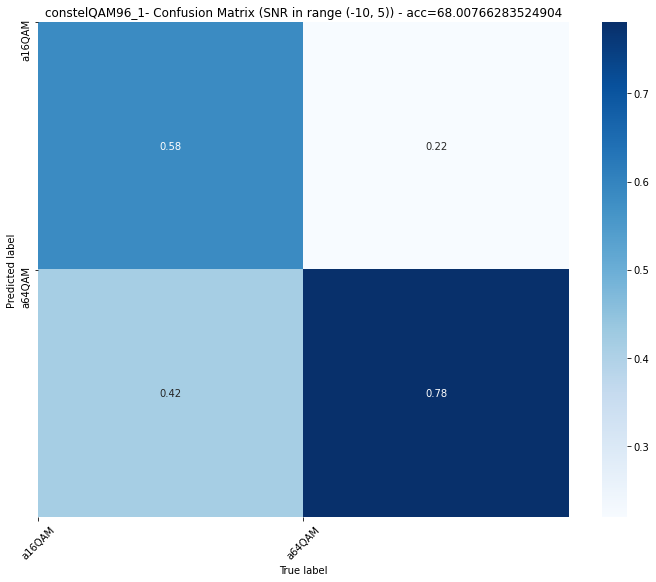

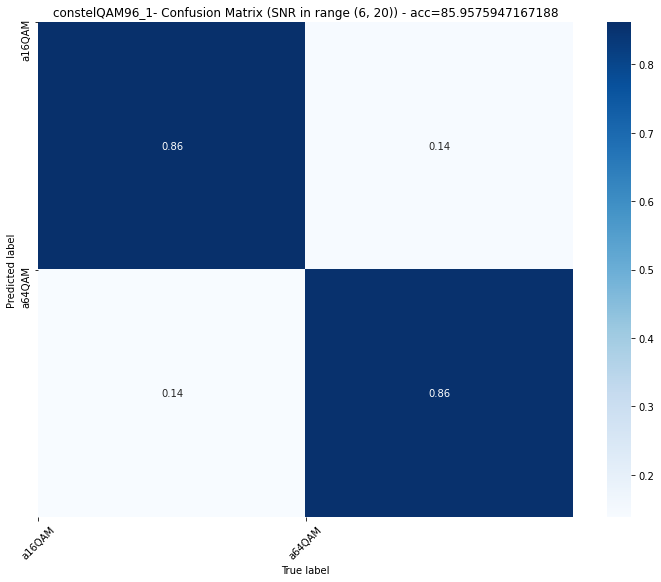

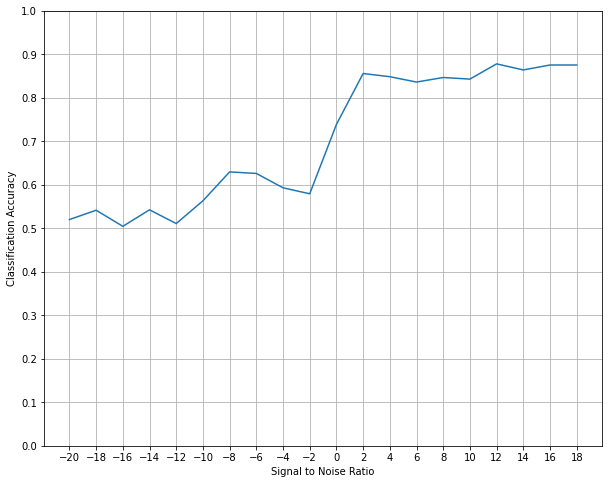

# Acting on insights: Combining models
In [Data-Driven Deep Learning for Automatic Modulation Recognition in Cognitive Radios](https://ieeexplore.ieee.org/document/8645696), the two-sequential model was proposed to combine the advantages of different feature representations.

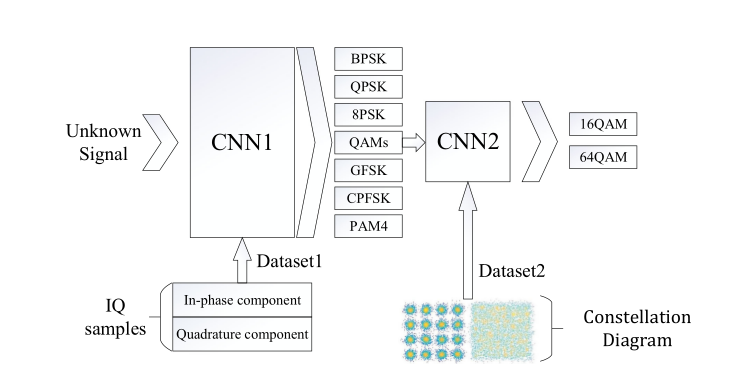

Based on our comparison earlier, we should use the IQ model as the initial model as it performs decently at low SNRs especially for easier categories like BPSK, 4PAM, GFSK, and CPFSK. However, it gets significantly confused for QAMs and higher order PSKs. This can be solved if we feed in QAMs and PSKs into the AP model, which is able to distinguish between them with higher accuracy at high SNRs.

In our case, it does not seem like the constellation model (even the 96-resolution) outperforms the AP model that significantly for QAM differentiation. I still think the constellation is quite promising, just that the number of points is too few, perhaps 1024 points would perform much better.

So I am going to combine CLDNN_IQ to identify five classes (BPSK, 4PAM, GFSK, CPFSK, QAMPSK), followed by CLDNN_AP to identify four classes (16QAM, 64QAM, QPSK, 8PSK).

## Train CNN_1 on five classes
Across entire SNR range, should also balance QAMPSK category to have similar numbers as the other category.

In [ ]:
from sklearn.externals import joblib
data = joblib.load(root_path + 'data/rml_trainvaltest.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

### Reformat data into 5 classes

In [ ]:
#relabel QAMs and high order PSKs as 'QAMPSK'
y_train = labels_train[:,0]
y_train[(y_train == 'a16QAM') | (y_train == 'a64QAM') | (y_train == 'bQPSK') | (y_train == 'b8PSK')] = 'QAMPSK'

y_val = labels_val[:,0]
y_val[(y_val == 'a16QAM') | (y_val == 'a64QAM') | (y_val == 'bQPSK') | (y_val == 'b8PSK')] = 'QAMPSK'

y_test = labels_test[:,0]
y_test[(y_test == 'a16QAM') | (y_test == 'a64QAM') | (y_test == 'bQPSK') | (y_test == 'b8PSK')] = 'QAMPSK'

y = labels_test[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
labels_test[idx][:,0] = y_test[idx]

In [ ]:
#check distribution of classes
uniq_train, counts_train = np.unique(y_train, return_counts=True)
uniq_val, counts_val = np.unique(y_val, return_counts=True)
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print(counts_train)
print(counts_val)
print(counts_test)

[53592 13452 13345 13502 13309]
[10362  2603  2598  2536  2701]
[16046  3945  4057  3962  3990]


In [ ]:
#only retain 0.25 of QAMPSK for training to maintain even proportion
idx = np.array(np.where(y_train == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_train.shape[0]) if i not in idx_throw ]
y_train = y_train[idx_keep]
X_train = X_train[idx_keep]

idx = np.array(np.where(y_val == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_val.shape[0]) if i not in idx_throw ]
y_val = y_val[idx_keep]
X_val = X_val[idx_keep]

idx = np.array(np.where(y_test == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_test.shape[0]) if i not in idx_throw ]
y_test = y_test[idx_keep]
X_test = X_test[idx_keep]
labels_test = labels_test[idx_keep]

In [ ]:
#check new distribution of classes
uniq_train, counts_train = np.unique(y_train, return_counts=True)
uniq_val, counts_val = np.unique(y_val, return_counts=True)
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print(counts_train)
print(counts_val)
print(counts_test)

[13398 13452 13345 13502 13309]
[2591 2603 2598 2536 2701]
[4012 3945 4057 3962 3990]


### Train cldnn iq on 5 classes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 1, 2, 132)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

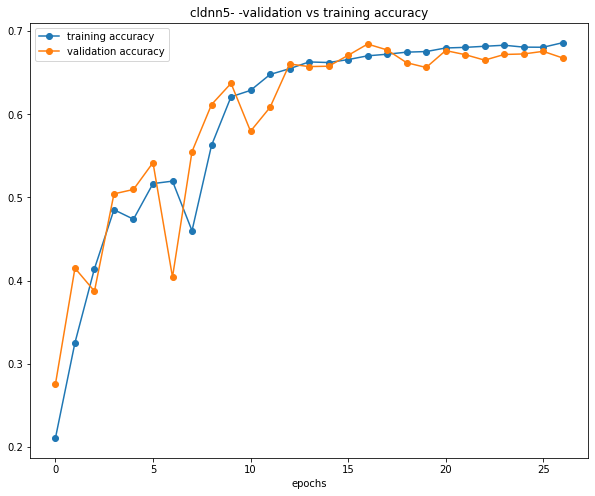

None

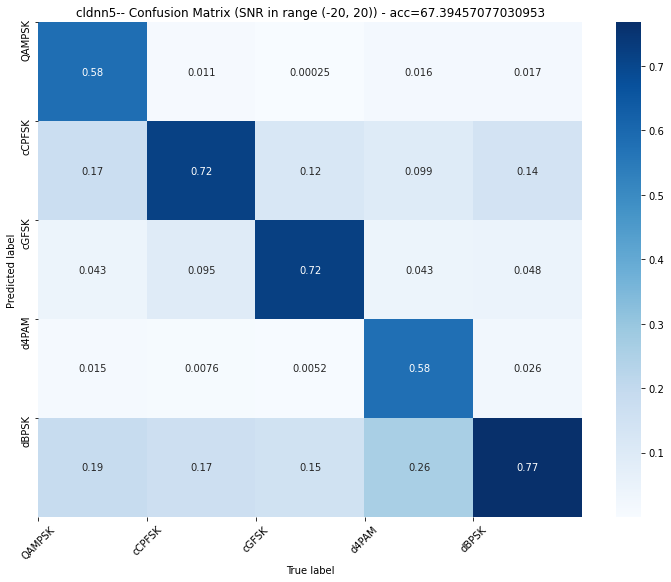

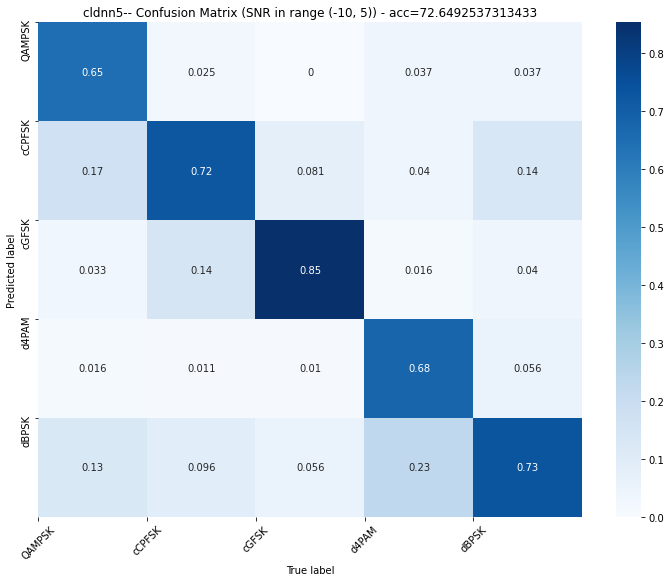

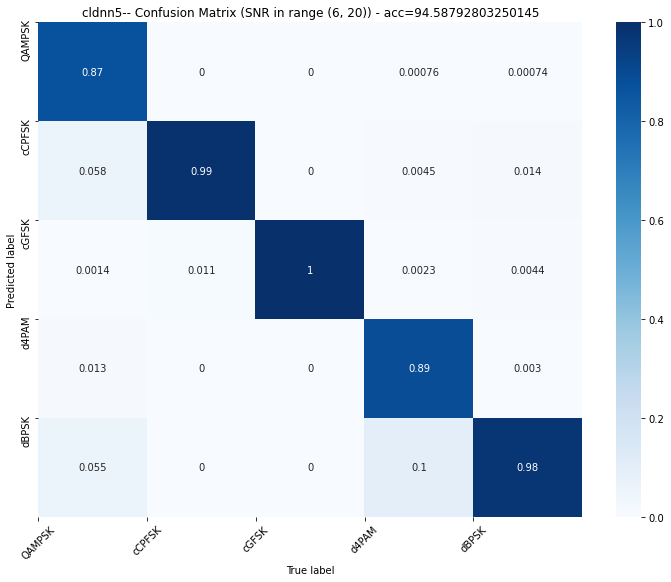

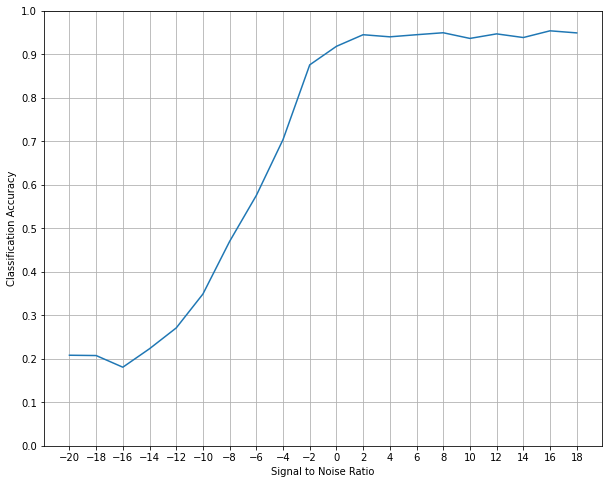

In [ ]:
NUM_CLASSES = 5
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn5-' )
cldnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_model_evaluater.print_summary()

This is surprisingly bad, when I trained CLDNN_IQ on all eight classes it was able to perform quite well on the easier classes??? But now it seems like 4PAM and QAMPSK have some slight confusion. This step should achieve close to 100% so I think we have to try another model.

### Train resnet iq on 5 classes
Resnet was the next best for iq data when I tried in the other notebook, and was actually quite close to cldnn_iq. Hopefully it performs better than CLDNN_IQ for the five classes.

#### Resnet CNN
From [Over-the-Air Deep Learning Based Radio
Signal Classification](https://arxiv.org/pdf/1712.04578.pdf)

Followed: https://medium.com/gsi-technology/residual-neural-networks-in-python-1796a57c2d7 

This CNN is based on ResNet which includes skip connections between convolution layers. Skip connections allow features to operate at multiple scales and depths through the network. This has led to significant improvements for both
CV and time-series audio tasks. 
The network used here contains 5 residual stacks.
In [Over-the-Air Deep Learning Based Radio
Signal Classification](https://arxiv.org/pdf/1712.04578.pdf), it was found that ResNet outperformed all other deep learning models when they tested it on the 2018.01A radioML dataset which had 1024 time-steps per sample.


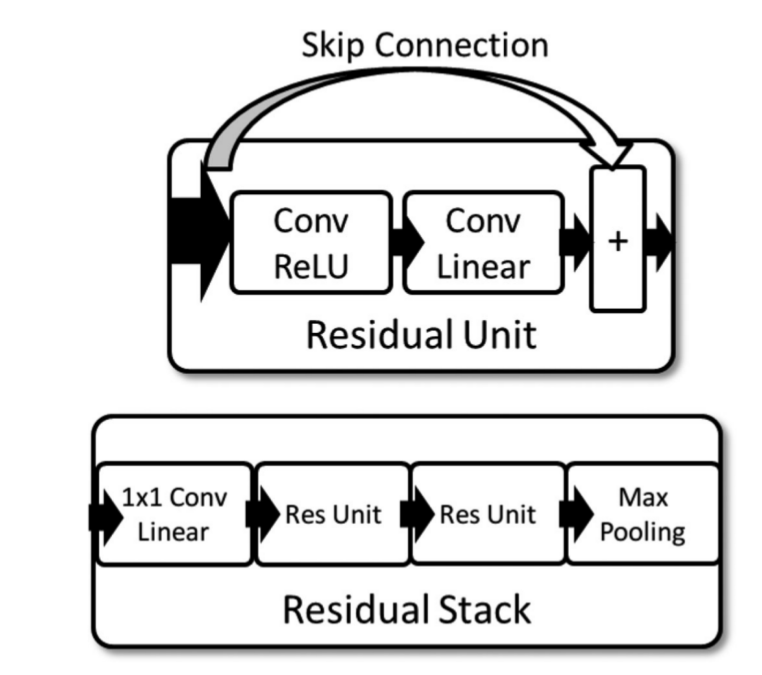

In [ ]:
# 1d conv resnet
def residual_stack(x, f):
    # 1x1 conv linear
    x = Conv1D(f, 1, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    # residual unit 1    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # residual unit 2    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides = 1, padding = "same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    return x

# define resnet model
def build_ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x)

    adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 40)      120         input_3[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 128, 40)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 128, 40)      4840        activation_3[0][0]               
___________________________________________________________________________________________

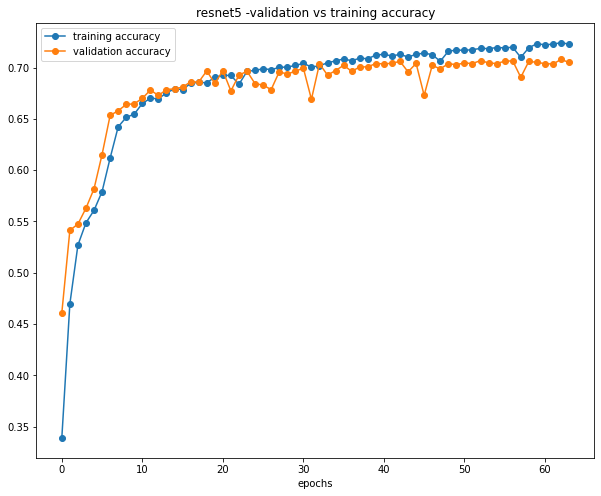

None

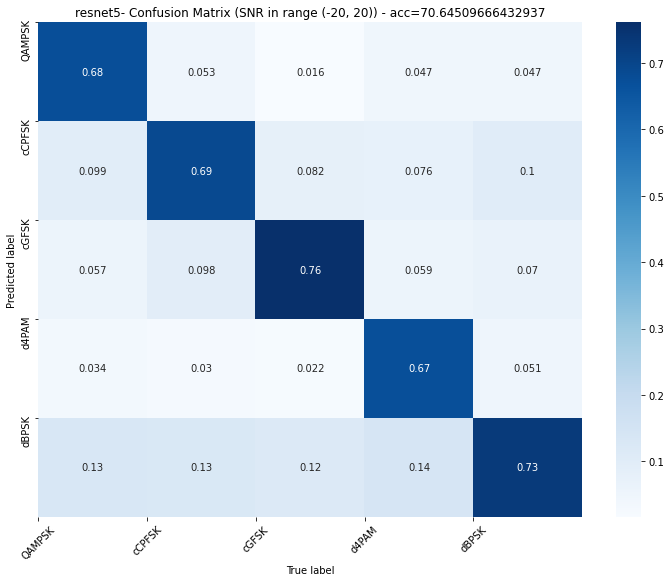

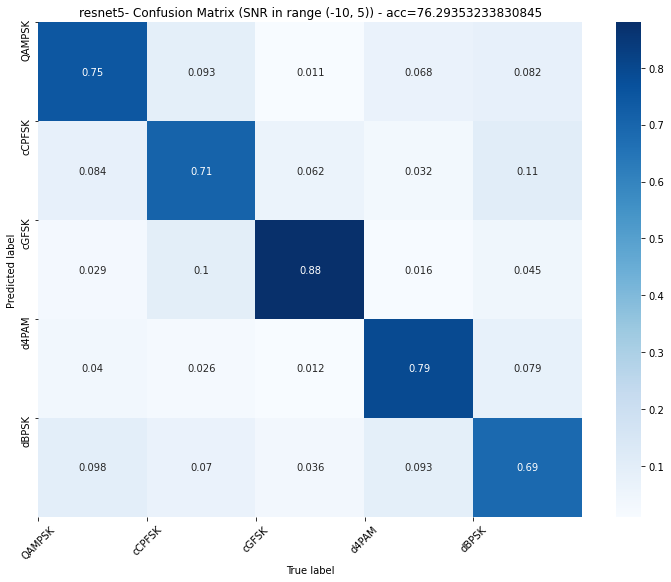

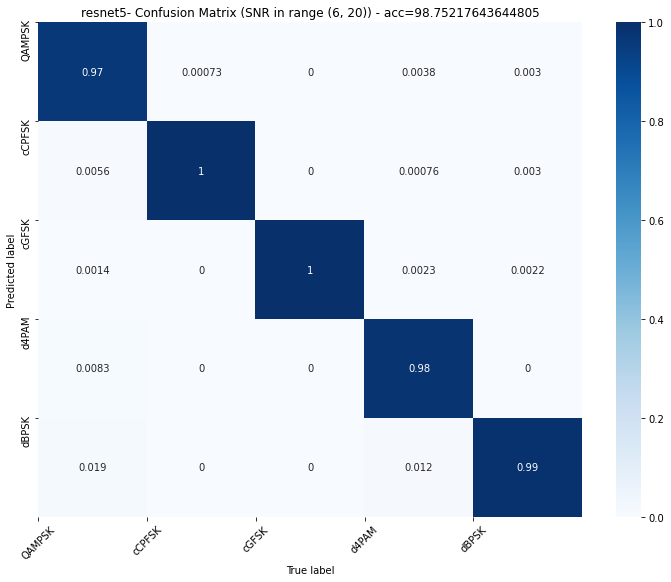

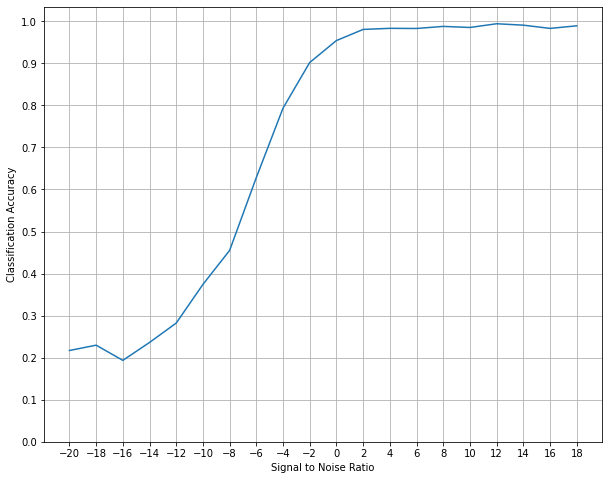

In [ ]:
NUM_CLASSES = 5
resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
resnet_model_evaluater = ModelEvaluater(resnet_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'resnet5', channels_first=False)
resnet_model_evaluater.fit(EPOCHS, patience=PATIENCE)
resnet_model_evaluater.print_summary()

Awesome, this is more like what I expected from the first stage CNN which should achieve close to 100% accuracy at high SNR. So now we choose resnet_iq for the first stage instead of cldnn_iq.

## Train CNN_2 on four classes

### Reformat data in four classes

In [ ]:
from sklearn.externals import joblib
data = joblib.load(root_path + 'data/rml_trainvaltest.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

In [ ]:
#Extract QAMs and PSKs only
y = labels_train[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
y_train = y[idx]
X_train = X_train[idx]

y = labels_val[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
y_val = y[idx]
X_val = X_val[idx]

y = labels_test[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
y_test = y[idx]
X_test = X_test[idx]
labels_test = labels_test[idx]

(array([     3,      4,     13, ..., 107195, 107196, 107198]),)


In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

### Train cldnn ap on 4 classes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 1, 2, 132)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

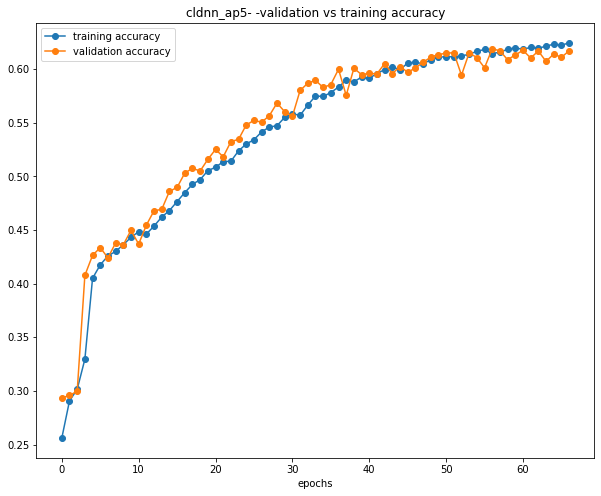

None

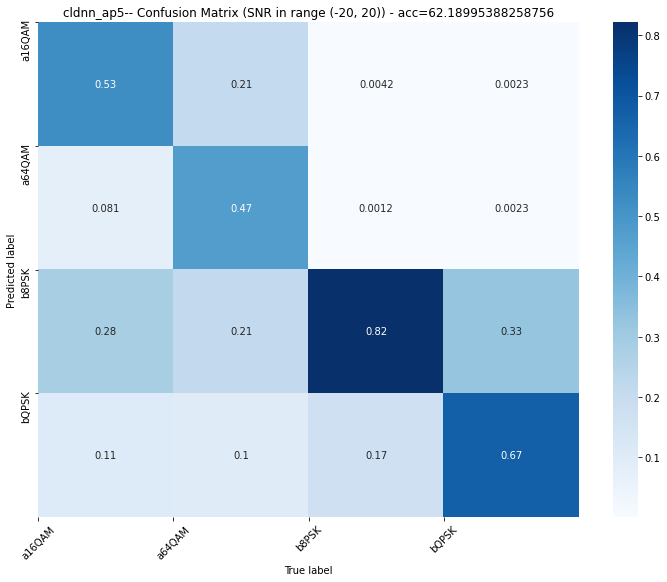

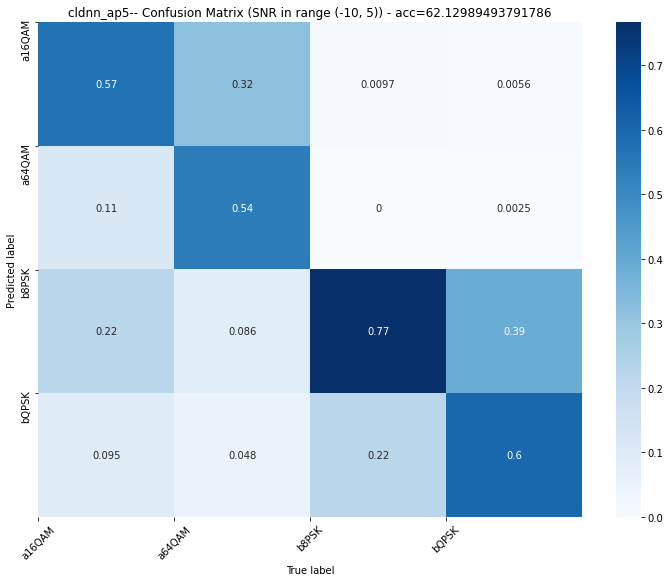

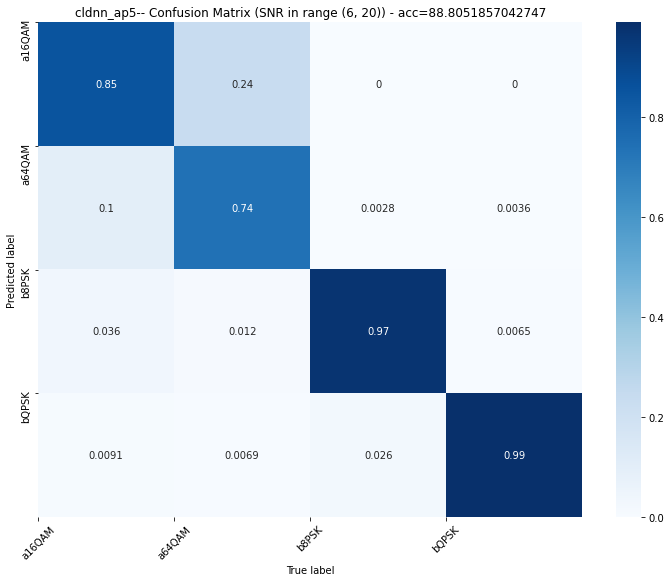

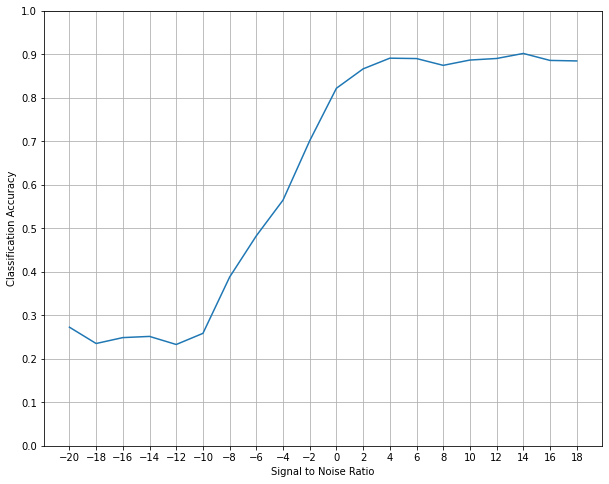

In [ ]:
NUM_CLASSES = 4
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap5-' )
cldnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_ap_model_evaluater.print_summary()

This is not too bad and is within expectations, because the QAMs are really hard to handle. But below high SNR, performance is quite bad.

## Combine resnet-iq model and cldnn-ap model

In [ ]:
#After a bit of guessing and validation
#Probs can use onehot also...
cnn1_classdict = {}
cnn1_classdict[0] = 'QAMPSK'
cnn1_classdict[1] = 'cCPFSK'
cnn1_classdict[2] = 'cGFSK'
cnn1_classdict[3] = 'd4PAM'
cnn1_classdict[4] = 'dBPSK'

cnn2_classdict = {}
cnn2_classdict[0] = 'a16QAM'
cnn2_classdict[1] = 'a64QAM'
cnn2_classdict[2] = 'b8PSK'
cnn2_classdict[3] = 'bQPSK'

mod_to_idx = {}
mod_to_idx['a16QAM'] = 0
mod_to_idx['a64QAM'] = 1
mod_to_idx['b8PSK'] = 2
mod_to_idx['bQPSK'] = 3
mod_to_idx['cCPFSK'] = 4
mod_to_idx['cGFSK'] = 5
mod_to_idx['d4PAM'] = 6
mod_to_idx['dBPSK'] = 7

In [ ]:
#combine predictions from cnn1 and cnn2
def combined_predict(X_test):
  #cnn1
  nclass = 5
  X_iq = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
  cnn_1 = build_ResNet((X_iq.shape[1], X_iq.shape[2]), nclass)
  cnn_1.load_weights(root_path + 'resnet5-weights-54.hdf5')

  out_prob = cnn_1.predict(X_iq)
  out_pred = np.argmax(out_prob,axis=1)
  out_pred = np.array([cnn1_classdict[i] for i in out_pred])

  idx = np.where(out_pred == 'QAMPSK')
  X_QAMPSK = X_test[idx]
  X_ap = arr_iq2ap(X_QAMPSK)

  #cnn2
  #NUM_CLASSES = 4
  X_ap = X_ap.reshape(X_ap.shape[0], 1, X_ap.shape[1], X_ap.shape[2])
  cnn_2 = build_cldnn_net(X_ap.shape[2], X_ap.shape[3])
  cnn_2.load_weights(root_path + 'cldnn_ap4--weights-57.hdf5')
  out_prob2 = cnn_2.predict(X_ap)
  out_pred2 = np.argmax(out_prob2,axis=1)
  out_pred2 = np.array([cnn2_classdict[i] for i in out_pred2])

  j = 0
  for i, out in enumerate(out_pred):
    if out=='QAMPSK':
      out_pred[i] = out_pred2[j]
      j = j+1
  
  return out_pred


#plot conf mat given predicted and true arrays
def createnplot_confmat(out_pred, y_true):
  confusion_mat = np.zeros([8,8])
  acc = np.mean(out_pred == y_true)
  # fill in the confusion matrix
  for i in range(y_true.shape[0]):
      true_idx = mod_to_idx[y_true[i]]
      pred_idx = mod_to_idx[out_pred[i]]          
      confusion_mat[pred_idx,true_idx] += 1

  # normalize the matrix column wise
  for i in range(8):
      if np.sum(confusion_mat[:,i]) > 0:
        confusion_mat[:,i] /= np.sum(confusion_mat[:,i])

  plot_confusion_matrix(confusion_mat, title=str(acc), labels = np.unique(labels_test[:,0]))


#return accuracies across snr range
def snr_accs(out_pred, labels_true):
  snr_accs = {}
  labels_snrs = np.array([int(snr) for snr in labels_true[:,1]])
  snrs_uniq = np.unique(labels_snrs)

  for snr in sorted(snrs_uniq):
    idx = np.where(labels_snrs == snr)
    y_pred = out_pred[idx]
    y_true = labels_true[idx][:,0]
    acc = np.mean(y_pred == y_true)
    snr_accs[snr] = acc
  return snr_accs

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 128, 40)      120         input_15[0][0]                   
__________________________________________________________________________________________________
activation_111 (Activation)     (None, 128, 40)      0           conv1d_101[0][0]                 
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, 128, 40)      4840        activation_111[0][0]             
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_31 (ZeroPadding2 (None, 1, 2, 132)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_31[0][0]          
__________________________________________________________________________________________________
dropout_55 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

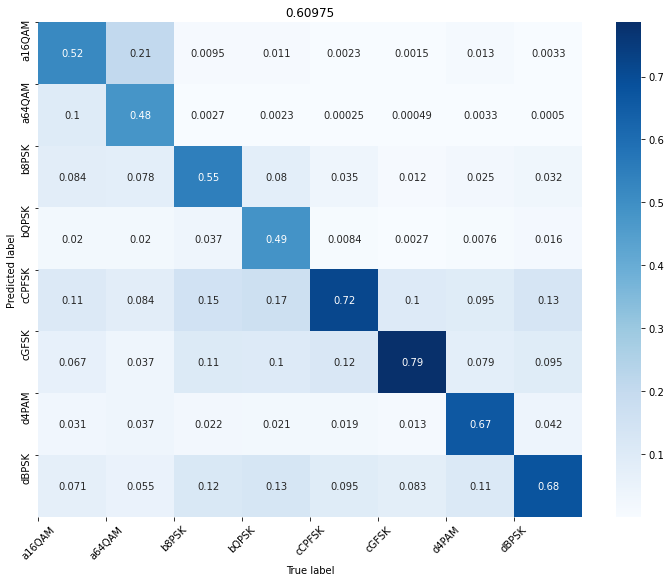

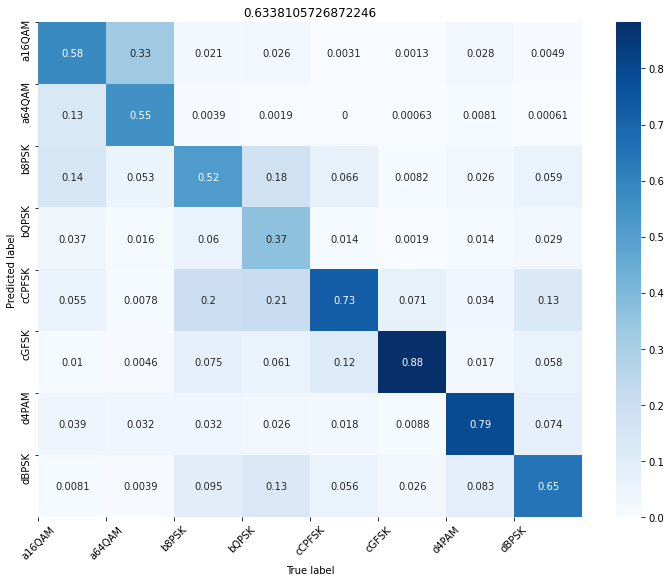

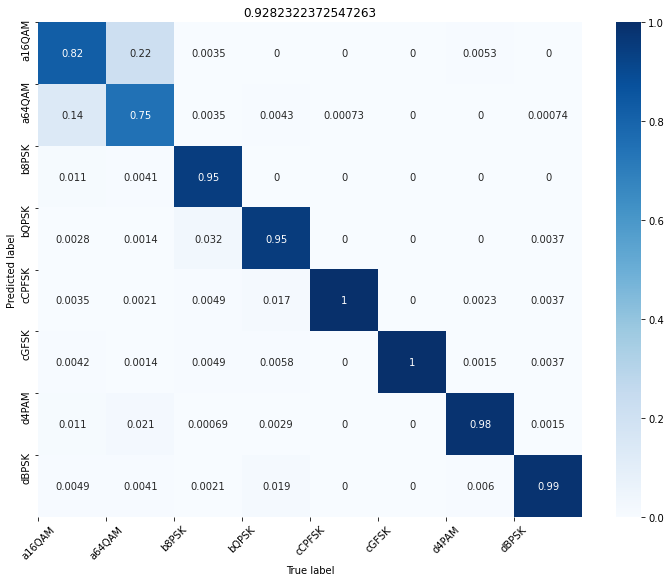

In [ ]:
#plot confusion matrices at different snr
NUM_CLASSES = 4
out_pred = combined_predict(X_test)

snr_ranges = [(-20, 20),(-10, 5), (6, 20)]
for i, snr_rng in enumerate(snr_ranges):
  snrs = np.array([int(lbl) for lbl in labels_test[:,1]])
  idx = np.where((snrs >= snr_rng[0]) & (snrs <=snr_rng[1]))
  
  y_pred_snr = out_pred[idx]
  y_snr = labels_test[idx][:,0]
  plt.subplot(1,3,i+1)
  createnplot_confmat(y_pred_snr, y_snr)
  plt.show()

In [ ]:
#combined predict
NUM_CLASSES = 4
out_combined = combined_predict(X_test)
combined_accpersnr = snr_accs(out_combined, labels_test)

NUM_CLASSES = 8
#CLDNN trained on low, med, high SNRs
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'cldnn8--weights-66.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_test2, y_test,X_test2, y_test, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8-' )
cldnn_accpersnr = cldnn_model_evaluater.accpersnr_model()


X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model.load_weights(root_path + 'cldnn_ap8--weights-68.hdf5')
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_test2, y_test, X_ap_test2, y_test, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8-' )
cldnn_ap_accpersnr = cldnn_ap_model_evaluater.accpersnr_model()

#Constellation
constellation_32_1_model = build_constellation_net(X_img_test.shape[1], X_img_test.shape[2], X_img_test.shape[3])
constellation_32_1_model.load_weights(root_path + 'constel32_1-weights-38.hdf5')
constellation_32_1_model_evaluater = ModelEvaluater(constellation_32_1_model, X_img_test, y_img_test, X_img_test, y_img_test, X_img_test, y_img_test, labels_img_test, 64, 'constel32_1' )
acc321 = constellation_32_1_model_evaluater.accpersnr_model()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 128, 40)      120         input_11[0][0]                   
__________________________________________________________________________________________________
activation_83 (Activation)      (None, 128, 40)      0           conv1d_76[0][0]                  
__________________________________________________________________________________________________
conv1d_77 (Conv1D)              (None, 128, 40)      4840        activation_83[0][0]              
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_22 (ZeroPadding2 (None, 1, 2, 132)    0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_22[0][0]          
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, name="dense2", kernel_initializer="he_normal")`


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_25 (ZeroPadding2 (None, 1, 2, 132)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_25[0][0]          
__________________________________________________________________________________________________
dropout_43 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The `input_dim` and `input_length` ar

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_28 (ZeroPadding2 (None, 1, 2, 132)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_28[0][0]          
__________________________________________________________________________________________________
dropout_47 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

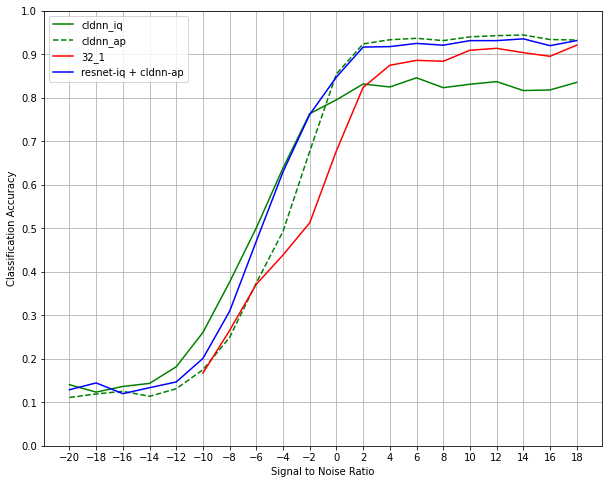

In [ ]:
# plot acc-vs-snr graphs for different models
cldnn, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g-', label='cldnn_iq')
cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g--', label='cldnn_ap')
_acc321,  = plt.plot(list(acc321.keys()),list(acc321.values()), 'r-', label='32_1')
combined, = plt.plot(list(combined_accpersnr.keys()),list(combined_accpersnr.values()), 'b-', label='resnet-iq + cldnn-ap')

plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.xticks(list(cldnn_accpersnr.keys()))
plt.legend(handles = [cldnn, cldnn_ap, _acc321, combined])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()

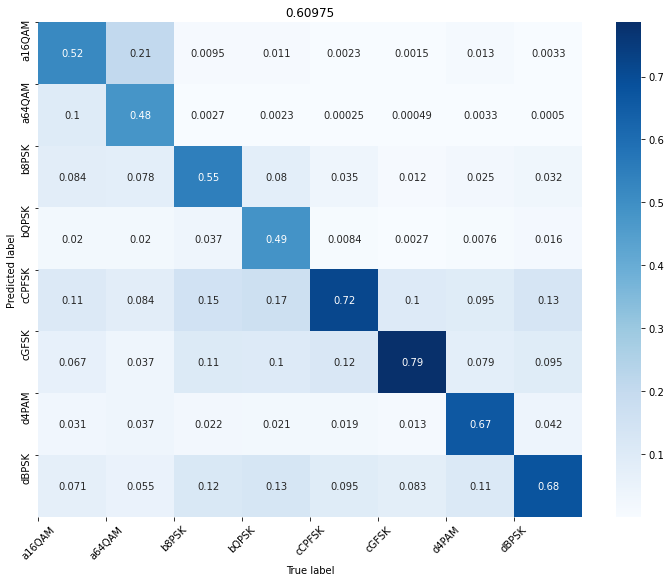

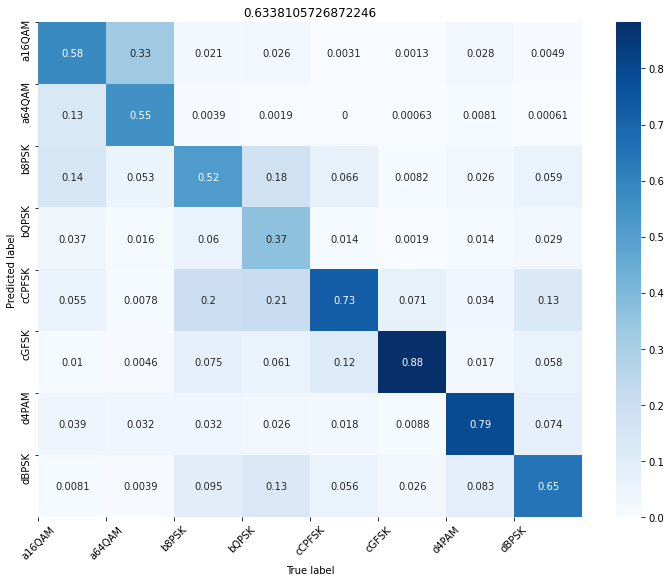

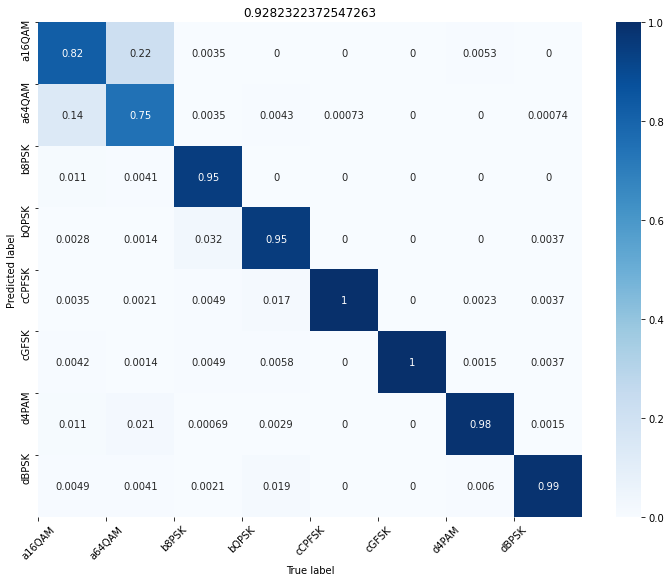

In [ ]:
#plot confusion matrix for all, low, med and high SNR
snr_ranges = [(-20, 20),(-10, 5), (6, 20)]
for i, snr_rng in enumerate(snr_ranges):
  snrs = np.array([int(lbl) for lbl in labels_test[:,1]])
  idx = np.where((snrs >= snr_rng[0]) & (snrs <=snr_rng[1]))
  
  y_pred_snr = out_pred[idx]
  y_snr = labels_test[idx][:,0]
  plt.subplot(1,3,i+1)
  createnplot_confmat(y_pred_snr, y_snr)
  plt.show()